In [1]:
import sys
sys.path.append('..')
import h5py
import yaml
import jax
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation
from flowrec.utils.py_helper import slice_from_tuple
from flowrec.utils.system import set_gpu
set_gpu(0,0.5)

In [ ]:
# plt.figure()
# plt.plot(loss_good_mse[:,0],loss_good_mse[:,1],label='physics')
# plt.plot(loss_good_mse[:,0],loss_good_mse[:,2],label='sensors')
# plt.yscale('log')
# plt.legend()
# plt.show()

In [8]:
# Get summary file
def summary(result_dir: Path):
    folder_list = list(result_dir.iterdir())

    ## get data
    with open(Path(list(folder_list)[0],'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
        cfg.data_config.data_dir = '.'+cfg.data_config.data_dir

    x_base = 132
    triangle_base_coords = [49,80]
    (ux,uy,pp) = simulation.read_data_2dtriangle(cfg.data_config.data_dir,x_base)
    x = np.stack([ux,uy,pp],axis=0)
    # remove parts where uz is not zero
    s = slice_from_tuple(cfg.data_config.slice_to_keep)
    x = x[s]

    [x_train,_,_], _ = data_utils.data_partition(x,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss

    [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))

    datainfo = data_utils.DataMetadata(
        re = cfg.data_config.re,
        discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
        axis_index=[0,1,2],
        problem_2d=True
    ).to_named_tuple()


    
    rng = jax.random.PRNGKey(10)

    ## for each run in the sweep, get summary
    summary_loss = []
    summary_name = []
    for d in folder_list:
        summary_name.append(str(d.name))
        print(d.name)
        with open(Path(d,'config.yml'),'r') as f:
            cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
        
        ## normalise
        if cfg.data_config.normalise:
            [ux_train_normal,uy_train_normal,pp_train_normal], train_minmax = data_utils.normalise(ux_train,uy_train,pp_train)
            ## take input
            pb_train = simulation.take_measurement_base(pp_train_normal,ly=triangle_base_coords,centrex=0)
        else:
            ## take input
            pb_train = simulation.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)

        u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
        pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
        take_observation, _ = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_train[0,...],example_pin_snapshot=pb_train[0,...])
        observed_train = take_observation(u_train)
        
        state = state_utils.restore_trainingstate(d,'state')
        _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
        mdl = make_model(cfg.model_config)
        pb_train_batch = np.array_split(pb_train,2,0)
        pred_train = []
        for inn in pb_train_batch:
            pred_train.append(mdl.apply(state.params,rng,inn,TRAINING=False))
        pred_train = np.concatenate(pred_train)
        if cfg.data_config.normalise:
            pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
        observed_pred = take_observation(pred_train)

        loss = np.array([
            losses.relative_error(pred_train, u_train),
            losses.divergence(pred_train[...,:-1], datainfo) + losses.momentum_loss(pred_train, datainfo),
            losses.mse(observed_pred, observed_train)
        ])
        summary_loss.append(loss)
        print(loss)
    
    summary_loss = np.array(summary_loss)
    with h5py.File(Path(result_dir,'summary.h5'),'w') as hf:
        hf.create_dataset('runs_name',data=list(summary_name),dtype=h5py.string_dtype(encoding='utf-8'))
        hf.create_dataset('runs_loss',data=summary_loss)

In [9]:
# summary(Path("../local_results/2dtriangle/sweep_loss_classic_fc2branch/"))
# summary(Path("../local_results/2dtriangle/sweep_loss_3_fc2branch/"))

bright-sweep-25
[0.448722   0.12332948 0.02958605]
giddy-sweep-19
[0.46104974 0.07899252 0.04577263]
sleek-sweep-21
[0.20480417 0.11331109 0.00431327]
dutiful-sweep-17
[0.4924179  0.28147152 0.00142764]
still-sweep-9
[0.508957   0.30293518 0.02084556]
splendid-sweep-31
[0.1329046  0.0739074  0.00704239]
youthful-sweep-29
[0.4377253  0.182475   0.00214234]
visionary-sweep-15
[0.48900452 0.27353978 0.00369305]
faithful-sweep-13
[0.11616343 0.03940477 0.00382209]
silvery-sweep-27
[0.5029934  0.4591803  0.02039833]
fragrant-sweep-30
[0.44149554 0.29761618 0.01120621]
blooming-sweep-7
[0.3917194  0.13575922 0.00829826]
celestial-sweep-20
[0.41309085 0.11731316 0.00494465]
denim-sweep-10
[8.1850894e-02 1.1828169e-02 7.2497634e-05]
quiet-sweep-26
[0.4954975  0.3796059  0.01351303]
lyric-sweep-22
[0.50744545 0.49114683 0.00926125]
true-sweep-16
[0.4138328  0.243981   0.00340726]
different-sweep-5
[0.45854622 0.09396175 0.04256133]
distinctive-sweep-12
[0.44249797 0.21167971 0.03023019]
peach-s

Load runs summary

In [15]:
sweep_dir_3 = Path('../local_results/2dtriangle/sweep_loss_3_fc2branch')
with h5py.File(Path(sweep_dir_3,'summary.h5'),'r') as hf:
    name_3 = np.array(hf.get('runs_name')).astype('unicode')
    loss_3 = np.array(hf.get('runs_loss'))


In [16]:
sweep_dir_classic = Path('../local_results/2dtriangle/sweep_loss_classic_fc2branch')
with h5py.File(Path(sweep_dir_classic,'summary.h5'),'r') as hf:
    name_classic = np.array(hf.get('runs_name')).astype('unicode')
    loss_classic = np.array(hf.get('runs_loss'))


plot statistics

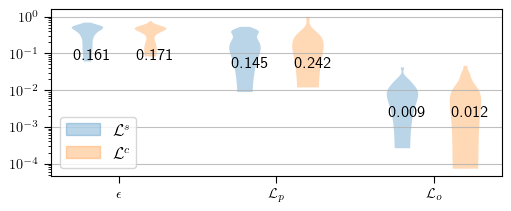

In [66]:
mean3 = np.mean(loss_3,axis=0)
std3 = np.std(loss_3,axis=0)
meanclassic = np.mean(loss_classic,axis=0)
stdclassic = np.std(loss_classic,axis=0)

fig,ax = plt.subplots(1,1,figsize=(5,2))
p3 = np.array([1.,2.,3.])-0.2
pc = np.array([1.,2.,3.])+0.2
ax.set(yscale='log',xticks=[1,2,3],xticklabels=['$\epsilon$','$\mathcal{L}_p$','$\mathcal{L}_o$'])
violin1 = ax.violinplot(loss_3,positions=p3,widths=0.2,showextrema=False)
violin2 = ax.violinplot(loss_classic,positions=pc,widths=0.2,showextrema=False)
ax.grid(axis='y')

labels = []
color = violin1["bodies"][0].get_facecolor().flatten()
labels.append((matplotlib.patches.Patch(color=color), '$\mathcal{L}^s$'))
color = violin2["bodies"][0].get_facecolor().flatten()
labels.append((matplotlib.patches.Patch(color=color), '$\mathcal{L}^c$'))

for i in range(3):
    ax.text(p3[i]-0.09,mean3[i]-mean3[i]/1.2,"{:.3f}".format(std3[i]))
    ax.text(pc[i]-0.09,mean3[i]-mean3[i]/1.2,"{:.3f}".format(stdclassic[i]))

plt.legend(*zip(*labels),loc=3)
# plt.savefig('./figs/clean_compare_lossfn')
plt.show()

In [65]:
print(np.count_nonzero(loss_3[:,0]>0.6))
print(np.count_nonzero(loss_classic[:,0]>0.6))

2
2


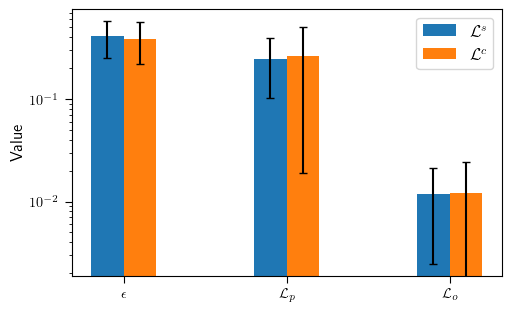

[0.16137023 0.14479    0.00939846] [0.17138515 0.24152589 0.01235111]


In [18]:

plt.figure(figsize=(5,3))
# plt.grid(axis='y')
plt.bar([0.9,1.9,2.9],mean3,width=0.2,yerr=std3,label='$\mathcal{L}^s$')
plt.bar([1.1,2.1,3.1],meanclassic,width=0.2,yerr=stdclassic,label='$\mathcal{L}^c$')
plt.yscale('log')
plt.ylabel('Value')
plt.legend()
plt.xticks(ticks=[1,2,3],labels=['$\epsilon$', '$\mathcal{L}_p$','$\mathcal{L}_o$'])
# plt.savefig('./figs/clean_compare_lossfn')
plt.show()
print(std3, stdclassic)

# Verify results
Verify that the 'good' ones are good and 'bad' ones are bad

1. Compare robustness with respect to the range of hyperparameters

In [67]:
import matplotlib.backends.backend_pdf

Load data and model for evaluation

In [72]:
# temp_results_dir = Path('../local_results/2dtriangle/sweep_loss_3_fc2branch/leafy-sweep-7')
# with open(Path(temp_results_dir,'config.yml'),'r') as f:
#     cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
#     cfg.data_config.data_dir = '.'+cfg.data_config.data_dir

# x_base = 132
# triangle_base_coords = [49,80]
# (ux,uy,pp) = simulation.read_data_2dtriangle(cfg.data_config.data_dir,x_base)
# x = np.stack([ux,uy,pp],axis=0)
# # remove parts where uz is not zero
# s = slice_from_tuple(cfg.data_config.slice_to_keep)
# x = x[s]

# [x_train,x_val,x_test], _ = data_utils.data_partition(x,
#     1,
#     cfg.data_config.train_test_split,
#     REMOVE_MEAN=cfg.data_config.remove_mean,
#     SHUFFLE=cfg.data_config.shuffle
# ) # Do not shuffle, do not remove mean for training with physics informed loss

# [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
# [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
# [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

# datainfo = data_utils.DataMetadata(
#     re = cfg.data_config.re,
#     discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
#     axis_index=[0,1,2],
#     problem_2d=True
# ).to_named_tuple()


/tmp/ipykernel_23711/785663374.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,3,figsize=(8,3))


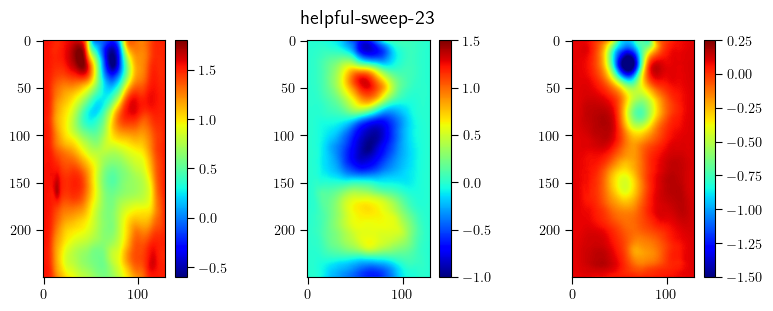

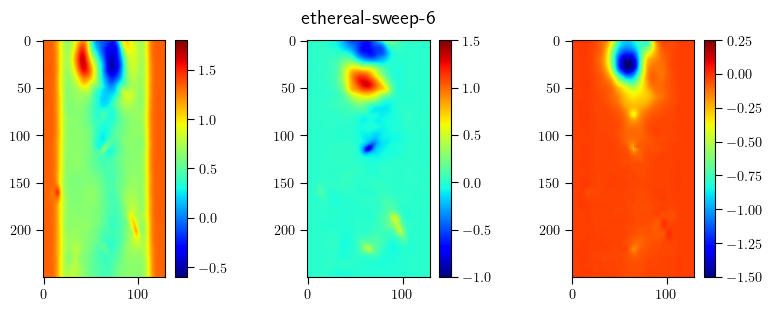

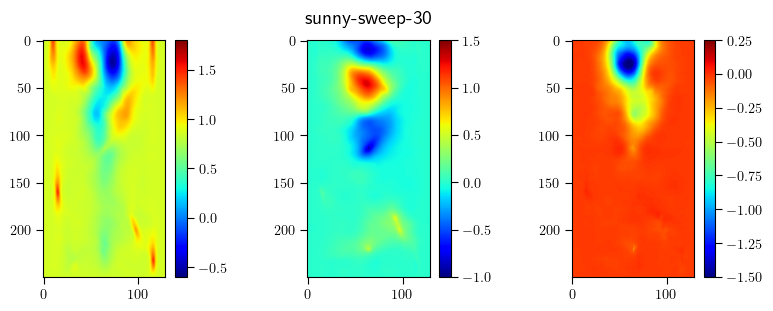

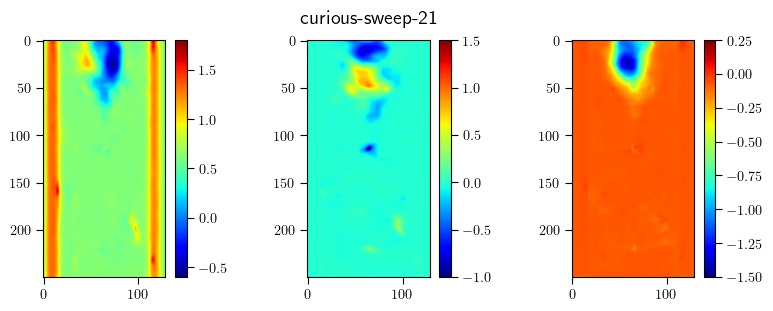

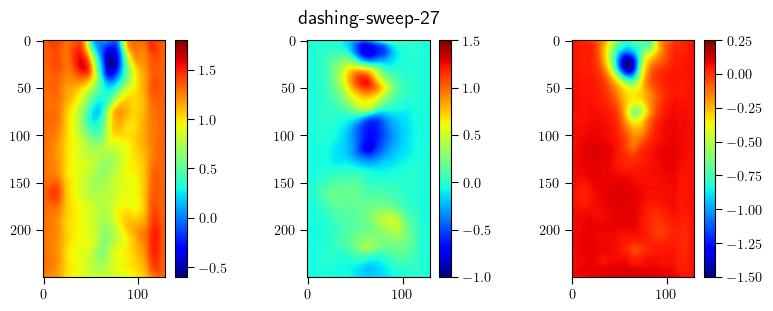

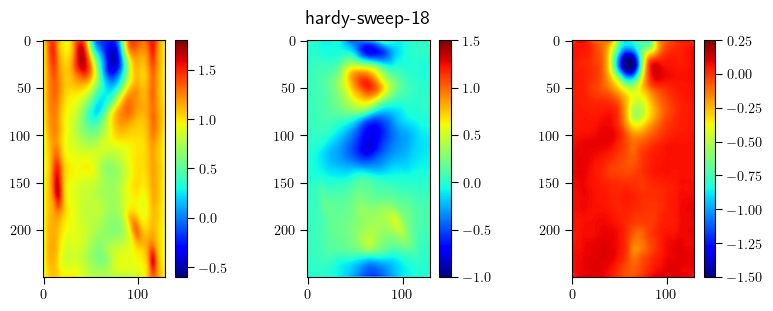

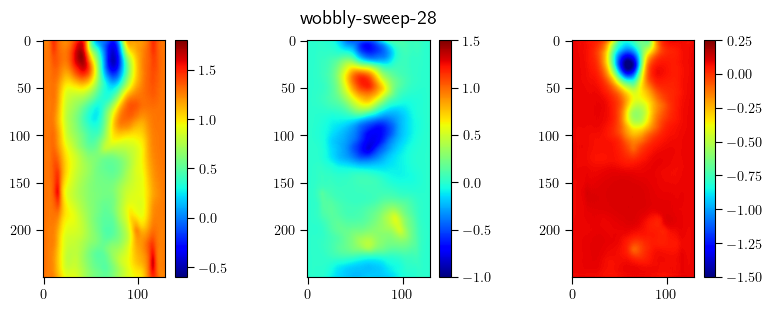

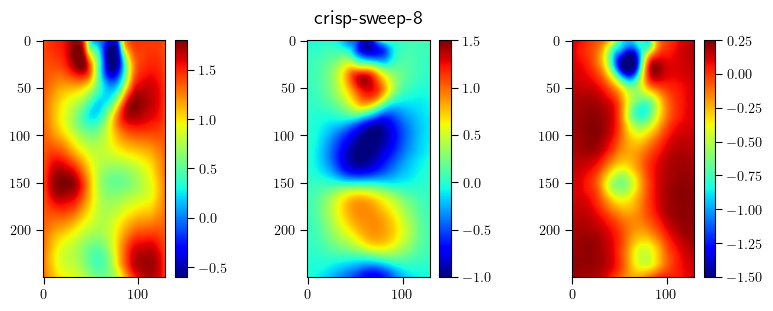

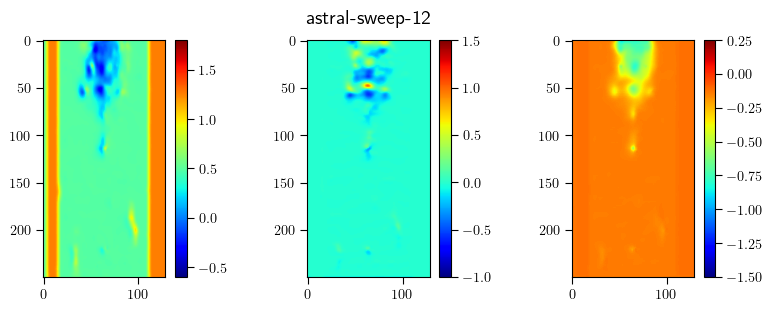

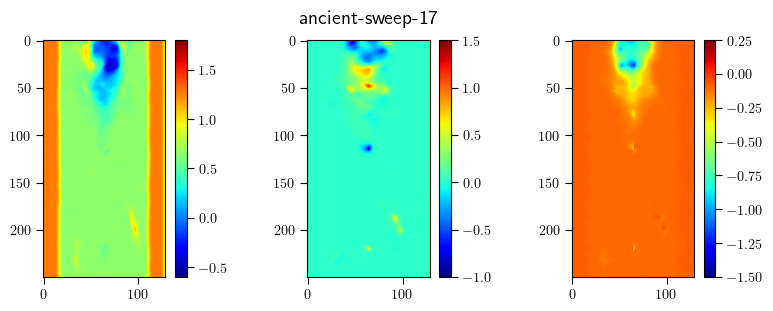

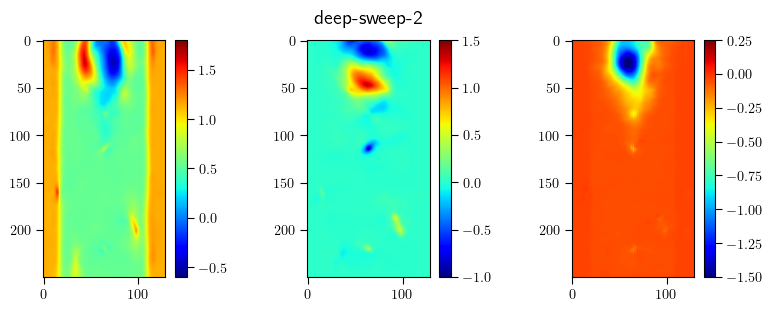

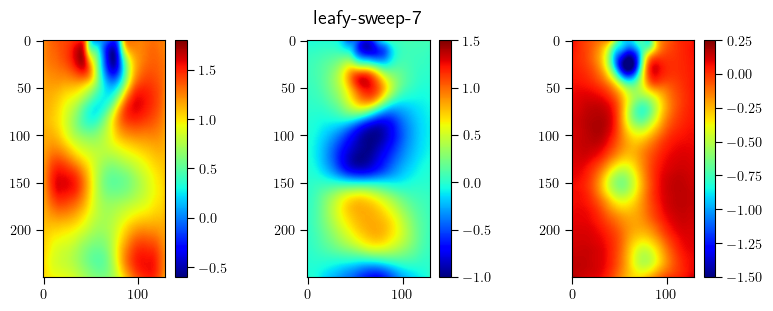

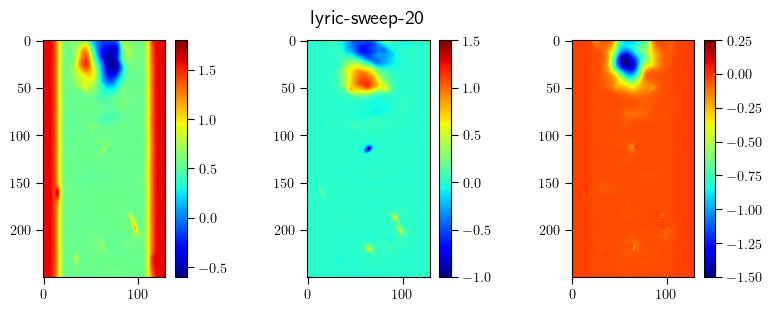

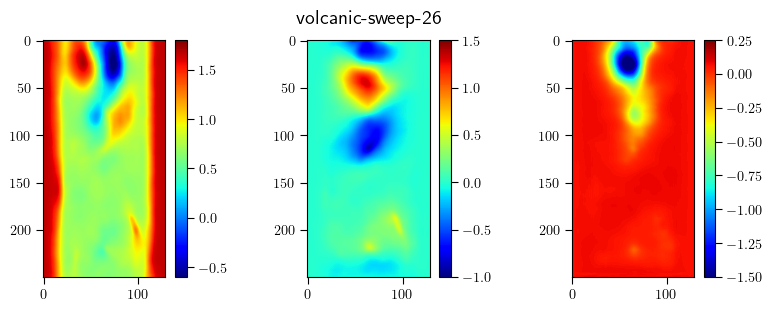

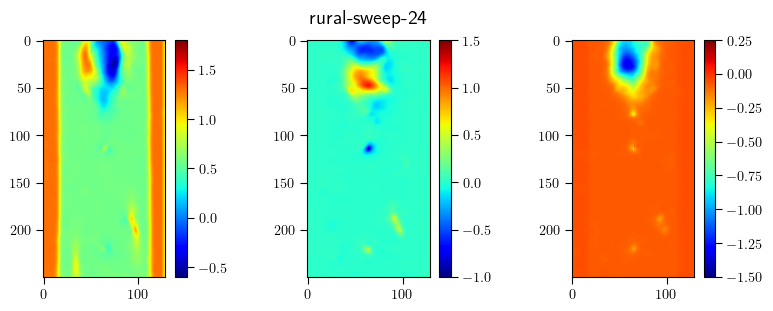

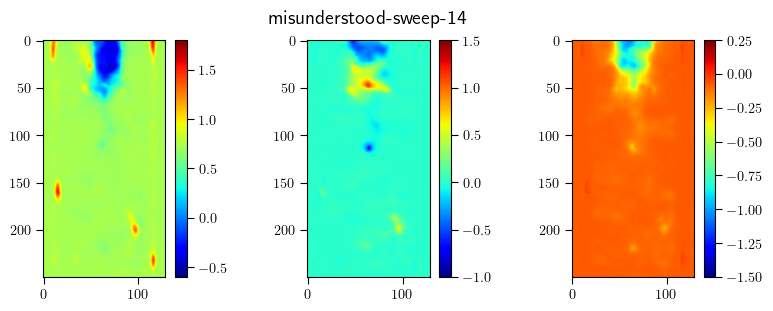

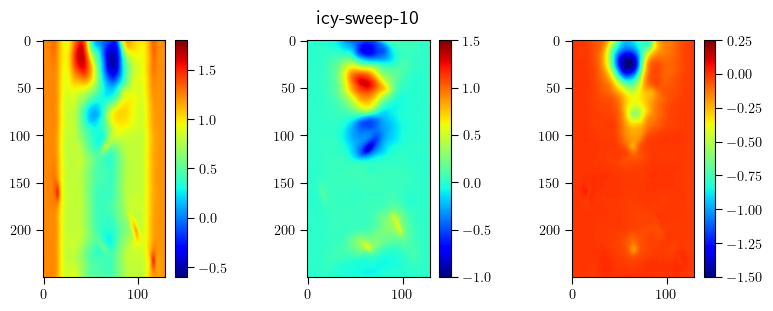

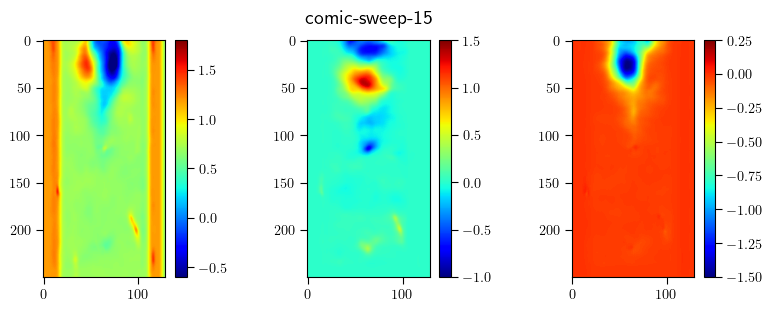

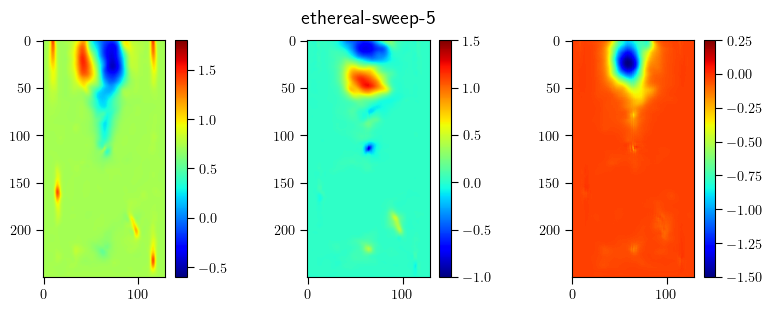

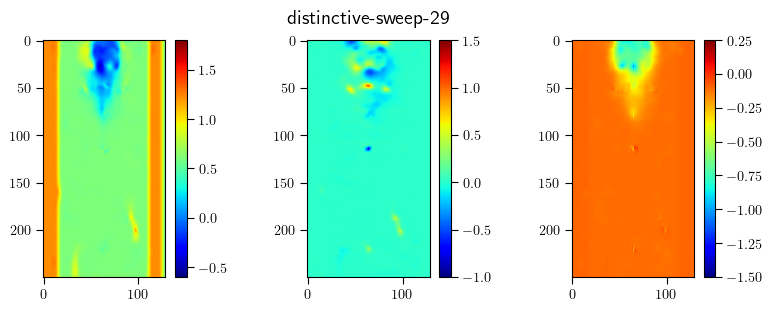

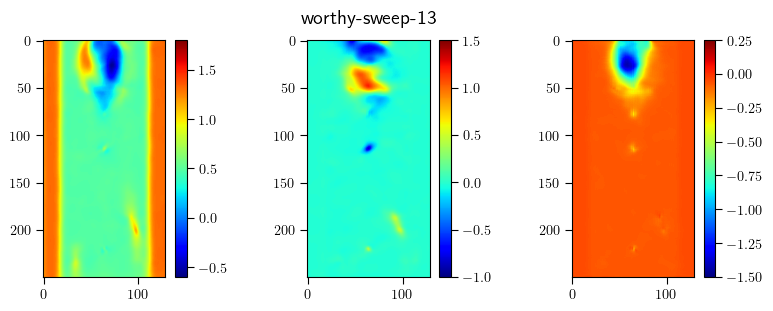

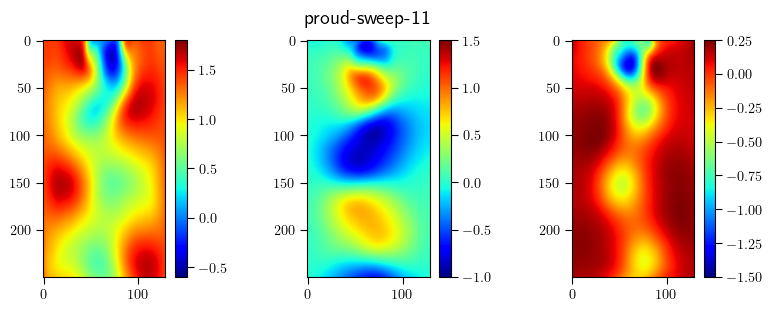

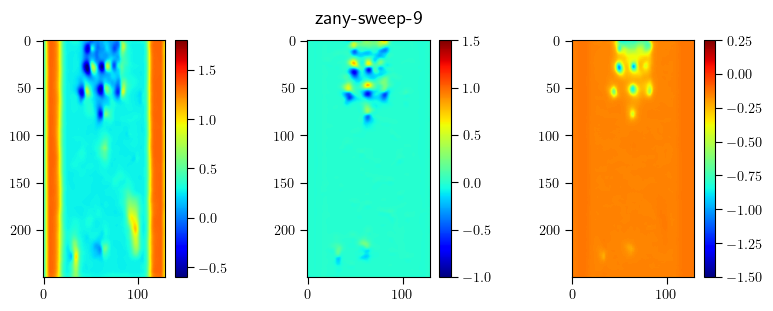

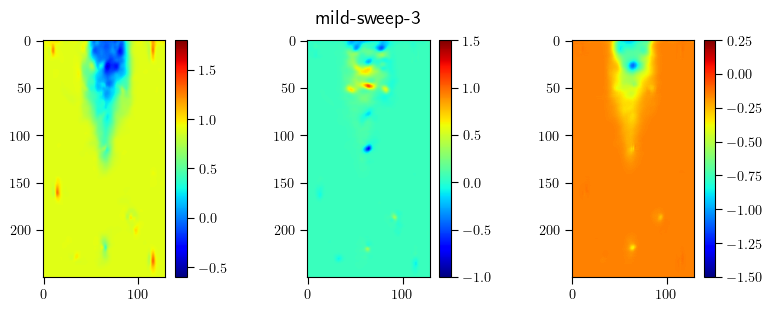

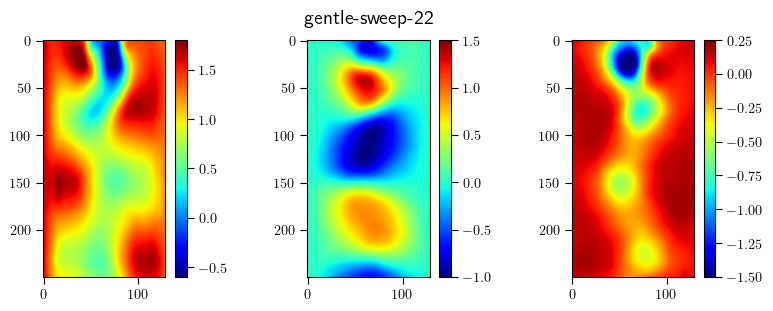

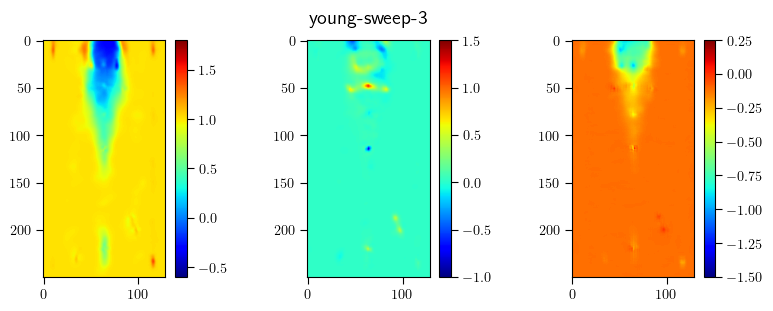

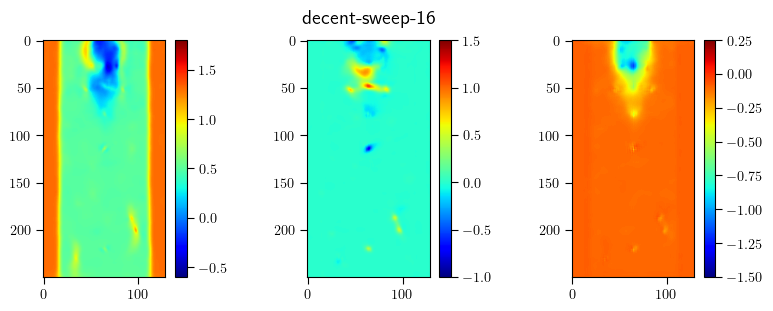

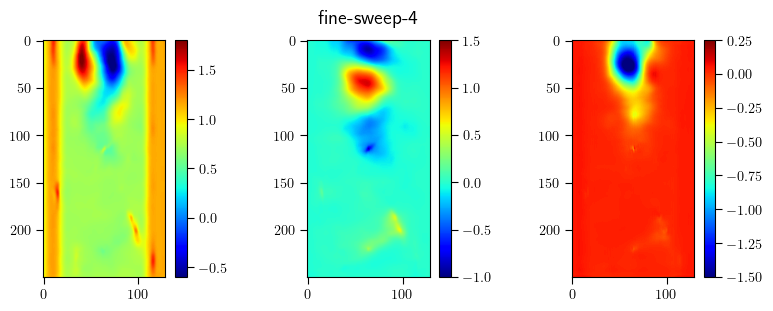

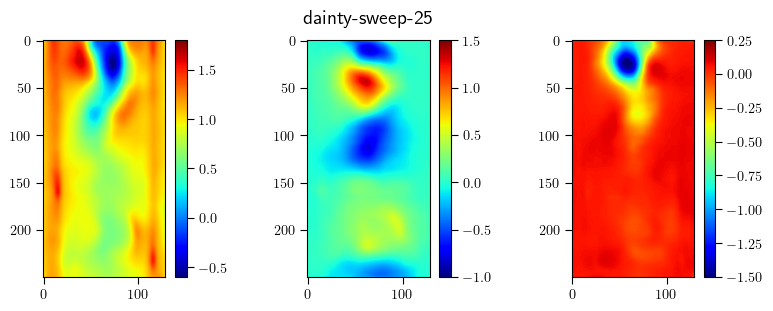

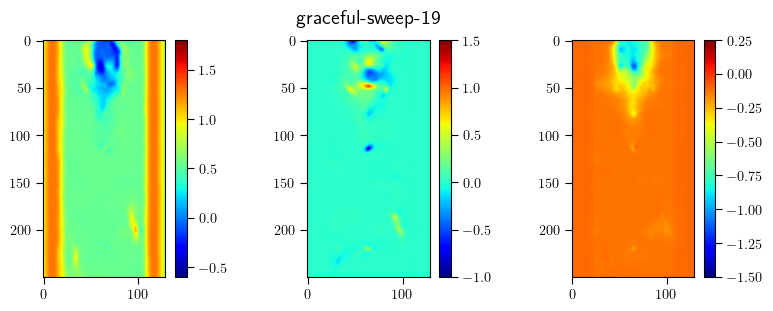

In [74]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("test3.pdf")

# for i in range(30):
#     sweep_name = name_3[i]
#     results_dir = Path(sweep_dir_3,sweep_name)
#     with open(Path(results_dir,'config.yml'),'r') as f:
#         cfg = yaml.load(f, Loader=yaml.UnsafeLoader)

#     ## normalise
#     if cfg.data_config.normalise:
#         # [ux_train_normal,uy_train_normal,pp_train_normal], train_minmax = data_utils.normalise(ux_train,uy_train,pp_train)
#         [ux_val_normal,uy_val_normal,pp_val_normal], val_minmax = data_utils.normalise(ux_val,uy_val,pp_val)
#         # [ux_test_normal,uy_test_normal,pp_test_normal], test_minmax = data_utils.normalise(ux_test,uy_test,pp_test)
#         ## take input
#         # pb_train = simulation.take_measurement_base(pp_train_normal,ly=triangle_base_coords,centrex=0)
#         pb_val = simulation.take_measurement_base(pp_val_normal,ly=triangle_base_coords,centrex=0)
#         # pb_test = simulation.take_measurement_base(pp_test_normal,ly=triangle_base_coords,centrex=0)
#     else:
#         ## take input
#         # pb_train = simulation.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
#         pb_val = simulation.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
#         # pb_test = simulation.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

#     # pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
#     pb_val = np.reshape(pb_val,(cfg.data_config.train_test_split[1],-1))
#     # pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

#     # u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
#     u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
#     # u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)


#     state = state_utils.restore_trainingstate(results_dir,'state')
#     _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
#     mdl = make_model(cfg.model_config)
#     rng = jax.random.PRNGKey(10)
#     pred_val = mdl.apply(state.params,rng,pb_val,TRAINING=False)
#     if cfg.data_config.normalise:
#         pred_val = data_utils.unnormalise_group(pred_val, val_minmax, axis_data=-1, axis_range=0)
    

#     take_observation, _ = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_val[0,...],example_pin_snapshot=pb_val[0,...])
    
#     # l_s_val = losses.mse(take_observation(pred_val),take_observation(u_val))
#     # l_d_val = np.mean(derivatives.div_field(pred_val[...,:-1],datainfo)**2)
#     # l_m_val = np.mean(derivatives.momentum_residual_field(pred_val,datainfo)**2)
#     # l_mse_clean = losses.relative_error(pred_val,u_val) 

#     fig,ax = plt.subplots(1,3,figsize=(8,3))
#     im1 = ax[0].imshow(pred_val[20,:,:,0],vmin=-0.6,vmax=1.8)
#     plt.colorbar(im1,ax=ax[0])
#     im2 = ax[1].imshow(pred_val[20,:,:,1],vmin=-1,vmax=1.5)
#     plt.colorbar(im2,ax=ax[1])
#     im3 = ax[2].imshow(pred_val[20,:,:,2],vmin=-1.5,vmax=0.25)
#     plt.colorbar(im3,ax=ax[2])
#     fig.suptitle(str(sweep_name))


# fig_nums = plt.get_fignums()  
# figs = [plt.figure(n) for n in fig_nums]
# for fig in figs: ## will open an empty extra figure :(
#     pdf.savefig(fig)
# pdf.close()